In [47]:
# Imports
import torch
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import sys
from random import randint

# Add the upper directory to the path
sys.path.append("../models/")
from CustomCNNVessel import CustomResNet

sys.path.append("../data/")
from VessMapDatasetLoader import vess_map_dataloader

torch.cuda.empty_cache()
device = torch.device("cuda")

In [48]:
# Dataloaders
image_dir = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap/images'
mask_dir = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap/labels'
skeleton_dir = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap/skeletons'

batch_size = 10
train_size = 0.8

train_loader, test_loader = vess_map_dataloader(image_dir, 
                                  mask_dir, 
                                  skeleton_dir, 
                                  batch_size,
                                  train_size = train_size)

In [49]:
# Models
model = CustomResNet(num_classes=2).to(device)
# Load the weights
model.load_state_dict(torch.load(f"../models/vess_map_regularized_none_200.pth"))

model_regularized_l1 = CustomResNet(num_classes=2).to(device)
# Load the weights
model_regularized_l1.load_state_dict(torch.load(f"../models/vess_map_regularized_l1_200.pth"))

model_regularized_l2 = CustomResNet(num_classes=2).to(device)
# Load the weights
model_regularized_l2.load_state_dict(torch.load(f"../models/vess_map_regularized_l2_200.pth"))

model = model.eval()
model_regularized_l1 = model_regularized_l1.eval()
model_regularized_l2 = model_regularized_l2.eval()

In [50]:
# Concating images
all_images = []
all_masks = []
all_skeletons = []

# Iterate through the entire train_loader
for batch in train_loader:
    images, masks, skeletons = batch
    images, masks, skeletons = images.to(device), masks.to(device), skeletons.to(device)

    all_images.extend(images)
    all_masks.extend(masks)
    all_skeletons.extend(skeletons)
    
for batch in test_loader:
    images, masks, skeletons = batch
    images, masks, skeletons = images.to(device), masks.to(device), skeletons.to(device)

    all_images.extend(images)
    all_masks.extend(masks)
    all_skeletons.extend(skeletons)

In [51]:
# Auxiliary functions
def positive_score(out, target = 1):
  search_domain = out[0, :, :]
  
  for i in range(randint(0, search_domain.shape[0] - 50), search_domain.shape[0]):
        for j in range(randint(0, search_domain.shape[0] - 50), search_domain.shape[1]):
            if search_domain[i, j] > 0:
                return (i, j)
  return None

def compute_softmax_gradient(model, image, skeleton, coordinates_array):
    # Ensure image requires gradient
    image = image.unsqueeze(0).requires_grad_()

    # Forward pass
    out = model(image)

    # Apply softmax to the output to get class probabilities
    probabilities = F.softmax(out, dim=1)

    # Get the score at the specified coordinates_array for class 1
    while True:
        result = positive_score(skeleton, 1)
        if result is not None:
            x, y = result
            if (x, y) not in coordinates_array:
                coordinates_array.append((x, y))
                break  # Exit the loop if a valid coordinate is found and added
        else:
            # Handle the case when no positive score is found
            # For example, break the loop, or choose a default coordinate, etc.
            break


    coordinates_array.append((x, y))
    score = probabilities[0, 1, x, y]  # Probability of class 1 at (x, y)

    # Compute gradients
    score.backward()

    # Return the gradient
    return image.grad


In [52]:
def process_model(model, all_images, all_skeletons, model_coordinates, model_gradients, model_probabilities, pixels_values):
    for i, (img, skeleton) in enumerate(zip(all_images, all_skeletons)):
        for j in range(10):
            # Compute the gradient at the specified coordinates
            gradient = compute_softmax_gradient(model, img, skeleton, model_coordinates)
            model_gradients.append(gradient.detach().cpu().numpy())

            coord_index = i * 10 + j
            coord = model_coordinates[coord_index]
            # Saving the pixel value for the given gradient
            pixel_value = img[0, coord[0], coord[1]]

            pixels_values.append(pixel_value.detach().cpu())
            
            output = model(img.unsqueeze(0))
            softmax_probs = F.softmax(output, dim=1)
            class_one_probs = softmax_probs[0, 1, coord[0], coord[1]].detach().cpu().numpy()
            model_probabilities.append(class_one_probs)

            if coord_index % 250 == 0:
                print(f'Prob and Grads {coord_index} generated')

# Initialize separate arrays for each model
models = [model, model_regularized_l1, model_regularized_l2]

# Assuming 'coordinates' is predefined
coordinates_model = []
coordinates_model_reg_l1 = []
coordinates_model_reg_l2 = []

gradients_model = []
gradients_model_reg_l1 = []
gradients_model_reg_l2 = []

probabilities_model = []
probabilities_model_reg_l1 = []
probabilities_model_reg_l2 = []

pixels_values_model = []
pixels_values_model_reg_l1 = []
pixels_values_model_reg_l2 = []

# Process each model
process_model(models[0], all_images, all_skeletons, coordinates_model, gradients_model, probabilities_model, pixels_values_model)
process_model(models[1], all_images, all_skeletons, coordinates_model_reg_l1, gradients_model_reg_l1, probabilities_model_reg_l1, pixels_values_model_reg_l1)
process_model(models[2], all_images, all_skeletons, coordinates_model_reg_l2, gradients_model_reg_l2, probabilities_model_reg_l2, pixels_values_model_reg_l2)


Prob and Grads 0 generated
Prob and Grads 250 generated
Prob and Grads 500 generated
Prob and Grads 750 generated
Prob and Grads 0 generated
Prob and Grads 250 generated
Prob and Grads 500 generated
Prob and Grads 750 generated
Prob and Grads 0 generated
Prob and Grads 250 generated
Prob and Grads 500 generated
Prob and Grads 750 generated


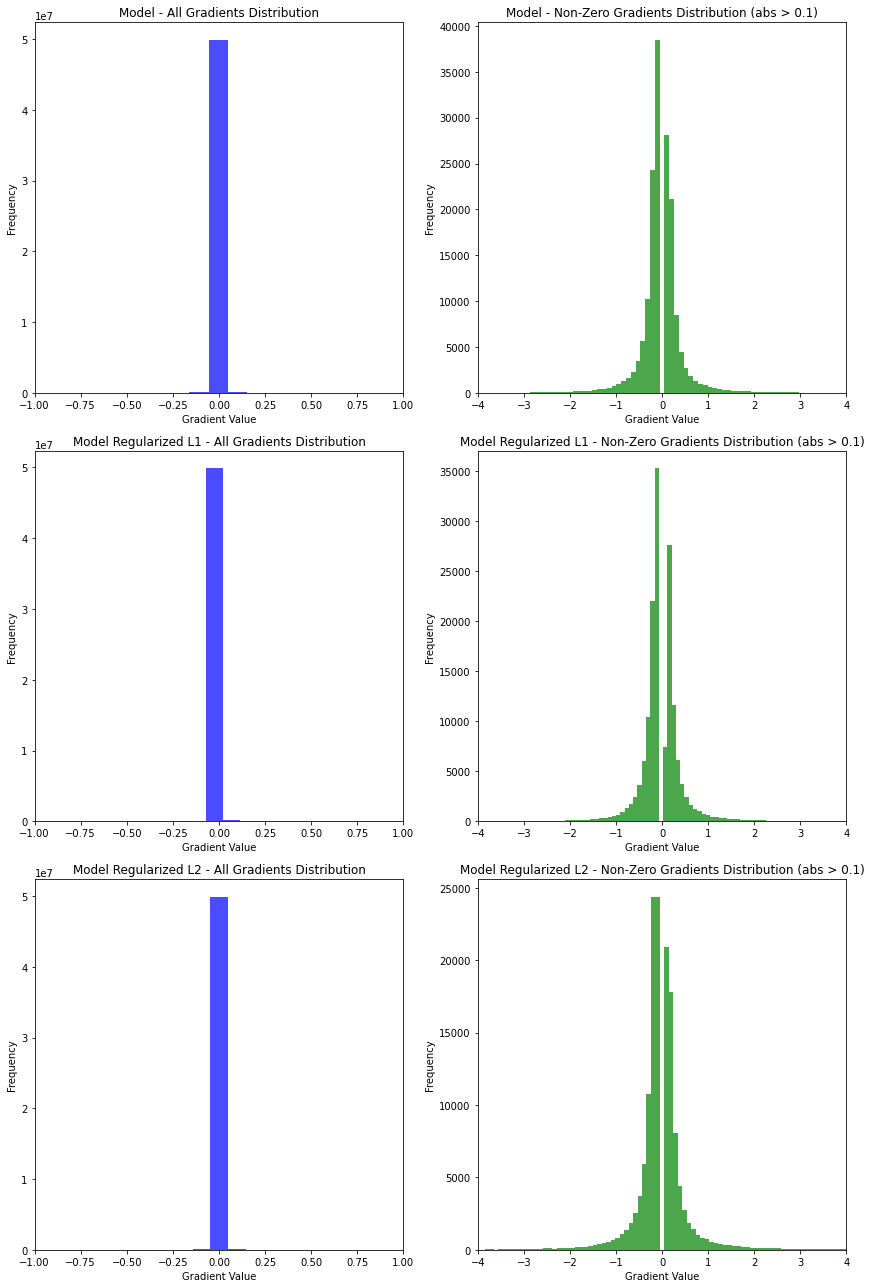

In [53]:
# Function to plot gradients
def plot_gradients(gradients, model_name, position):
    all_gradients = np.concatenate([grad.flatten() for grad in gradients])

    plt.subplot(3, 2, position)
    plt.hist(all_gradients, bins=300, color='blue', alpha=0.7)
    plt.xlim((-1, 1))
    plt.title(f'{model_name} - All Gradients Distribution')
    plt.xlabel('Gradient Value')
    plt.ylabel('Frequency')

    # Filter gradients with absolute value above the threshold (0.1)
    threshold = 0.1
    non_zero_gradients = all_gradients[np.abs(all_gradients) > threshold]

    plt.subplot(3, 2, position + 1)
    plt.hist(non_zero_gradients, bins=300, color='green', alpha=0.7)
    plt.xlim((-4, 4))
    plt.title(f'{model_name} - Non-Zero Gradients Distribution (abs > 0.1)')
    plt.xlabel('Gradient Value')
    plt.ylabel('Frequency')

# Plotting for each model
plt.figure(figsize=(12, 18))

plot_gradients(gradients_model, "Model", 1)
plot_gradients(gradients_model_reg_l1, "Model Regularized L1", 3)
plot_gradients(gradients_model_reg_l2, "Model Regularized L2", 5)

plt.tight_layout()
plt.show()


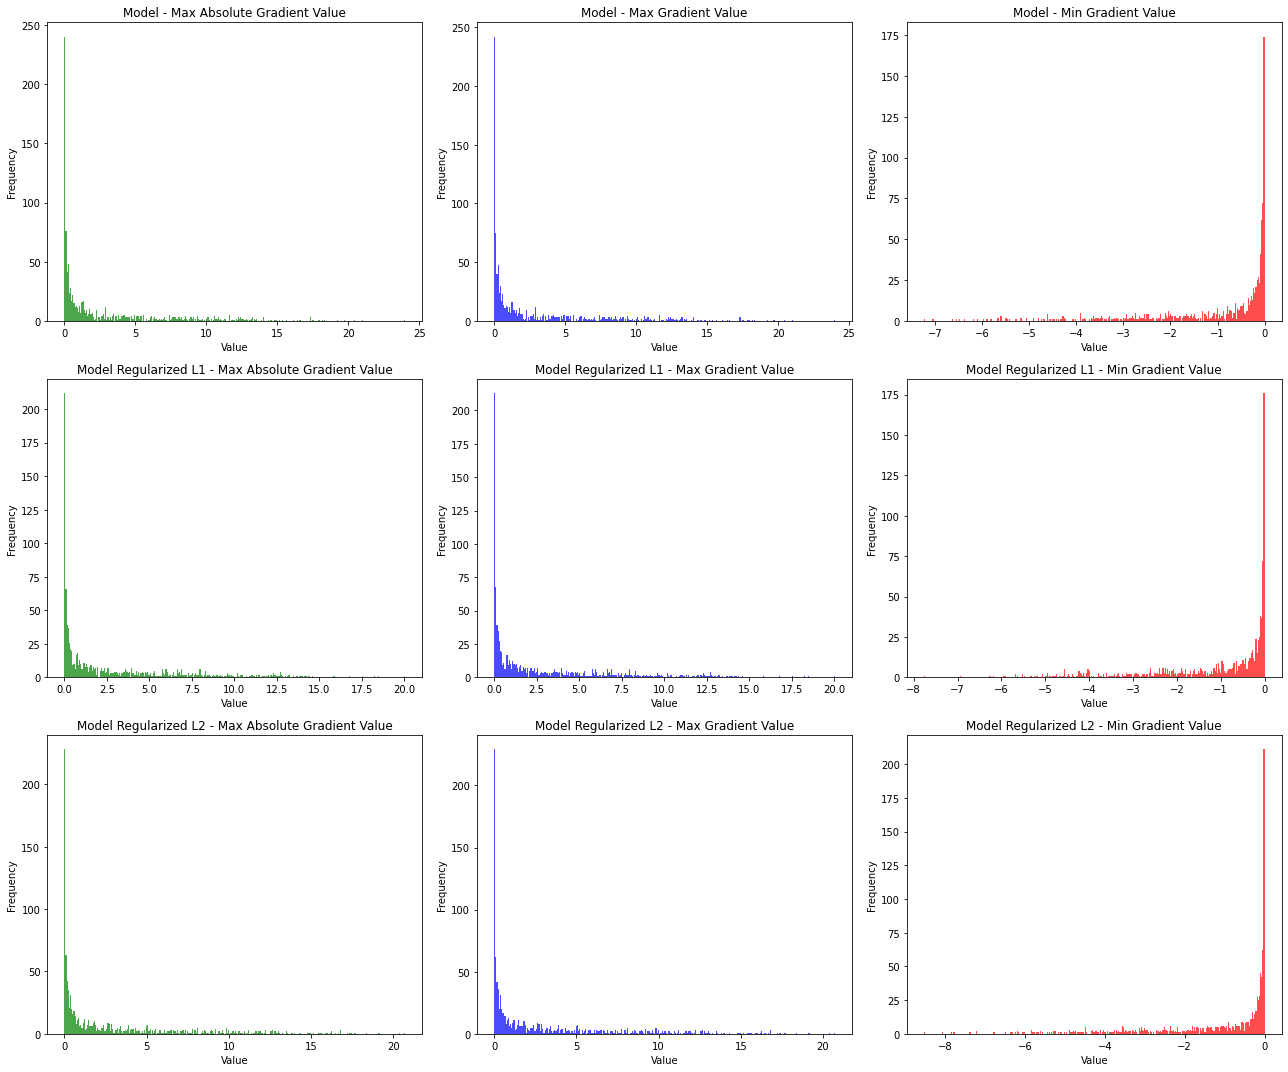

In [54]:
# Function to process gradients and plot histograms
def plot_gradient_stats(gradients, model_name, position):
    max_abs_values = []  # Store maximum absolute values of gradients
    min_values = []      # Store minimum values of gradients
    max_values = []      # Store maximum values of gradients

    for grad in gradients:
        grad_flat = grad.flatten()
        max_abs_values.append(np.max(np.abs(grad_flat)))
        min_values.append(np.min(grad_flat))
        max_values.append(np.max(grad_flat))

    # Plot histogram for maximum absolute values
    plt.subplot(3, 3, position)
    plt.hist(max_abs_values, bins=300, color='green', alpha=0.7)
    plt.title(f'{model_name} - Max Absolute Gradient Value')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    # Plot histogram for maximum values
    plt.subplot(3, 3, position + 1)
    plt.hist(max_values, bins=300, color='blue', alpha=0.7)
    plt.title(f'{model_name} - Max Gradient Value')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    # Plot histogram for minimum values
    plt.subplot(3, 3, position + 2)
    plt.hist(min_values, bins=300, color='red', alpha=0.7)
    plt.title(f'{model_name} - Min Gradient Value')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

# Plotting for each model
plt.figure(figsize=(18, 15))

plot_gradient_stats(gradients_model, "Model", 1)
plot_gradient_stats(gradients_model_reg_l1, "Model Regularized L1", 4)
plot_gradient_stats(gradients_model_reg_l2, "Model Regularized L2", 7)

plt.tight_layout()
plt.show()

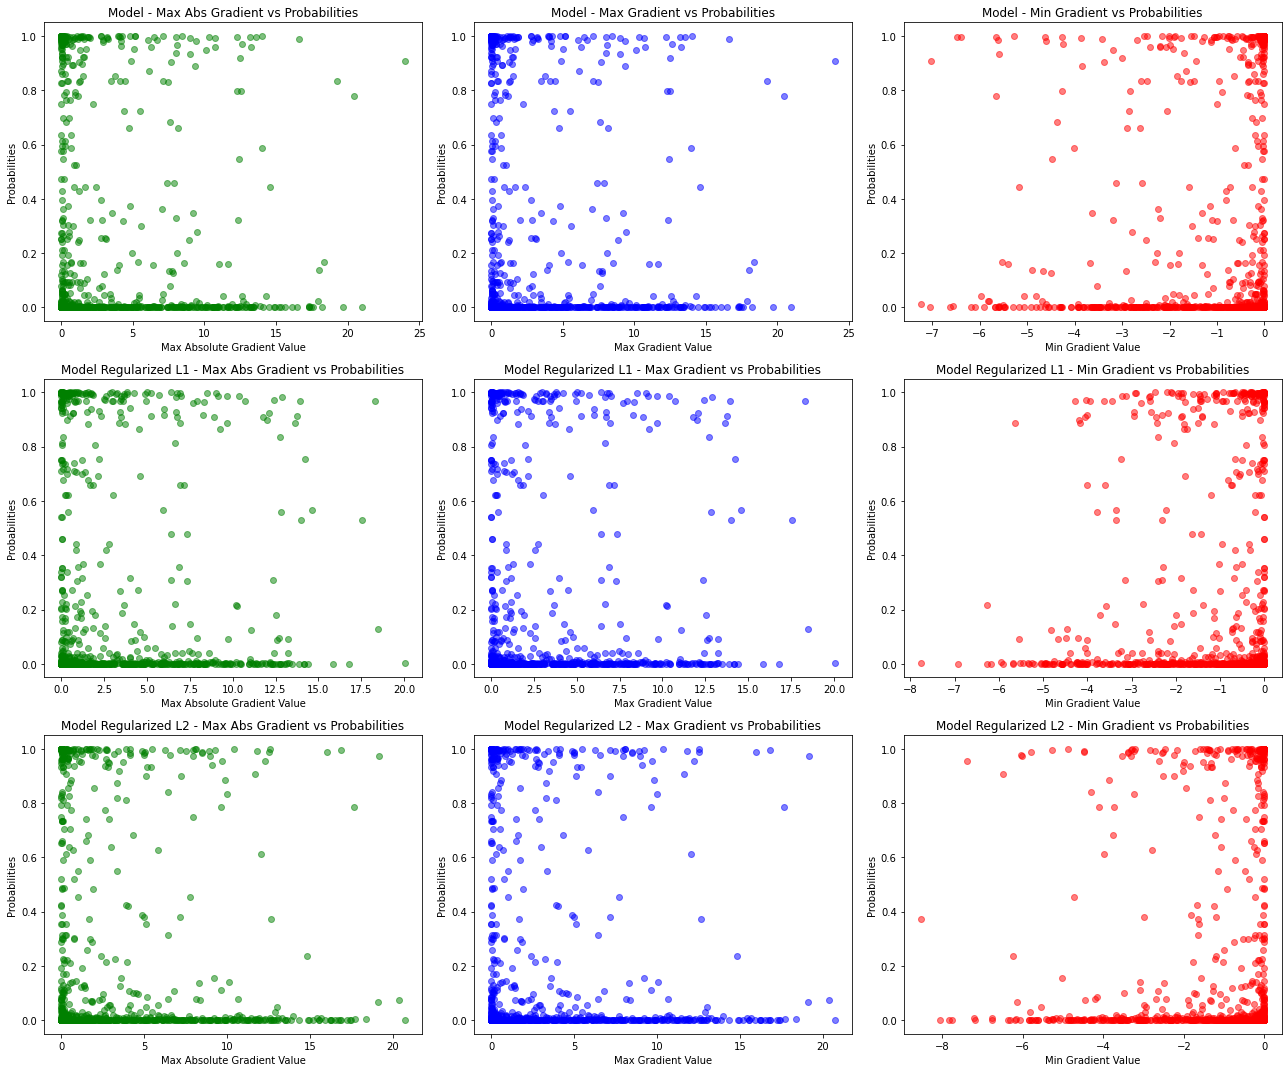

In [55]:
# Function to plot scatter plots for gradient statistics vs probabilities
def plot_scatter_stats(gradients, probabilities, model_name, position):
    max_abs_values = [np.max(np.abs(grad.flatten())) for grad in gradients]
    max_values = [np.max(grad.flatten()) for grad in gradients]
    min_values = [np.min(grad.flatten()) for grad in gradients]

    # Scatter plot for max_abs_values vs probabilities
    plt.subplot(3, 3, position)
    plt.scatter(max_abs_values, probabilities, c='green', alpha=0.5)
    plt.title(f'{model_name} - Max Abs Gradient vs Probabilities')
    plt.xlabel('Max Absolute Gradient Value')
    plt.ylabel('Probabilities')

    # Scatter plot for max_values vs probabilities
    plt.subplot(3, 3, position + 1)
    plt.scatter(max_values, probabilities, c='blue', alpha=0.5)
    plt.title(f'{model_name} - Max Gradient vs Probabilities')
    plt.xlabel('Max Gradient Value')
    plt.ylabel('Probabilities')

    # Scatter plot for min_values vs probabilities
    plt.subplot(3, 3, position + 2)
    plt.scatter(min_values, probabilities, c='red', alpha=0.5)
    plt.title(f'{model_name} - Min Gradient vs Probabilities')
    plt.xlabel('Min Gradient Value')
    plt.ylabel('Probabilities')

# Plotting for each model
plt.figure(figsize=(18, 15))

plot_scatter_stats(gradients_model, probabilities_model, "Model", 1)
plot_scatter_stats(gradients_model_reg_l1, probabilities_model_reg_l1, "Model Regularized L1", 4)
plot_scatter_stats(gradients_model_reg_l2, probabilities_model_reg_l2, "Model Regularized L2", 7)

plt.tight_layout()
plt.show()

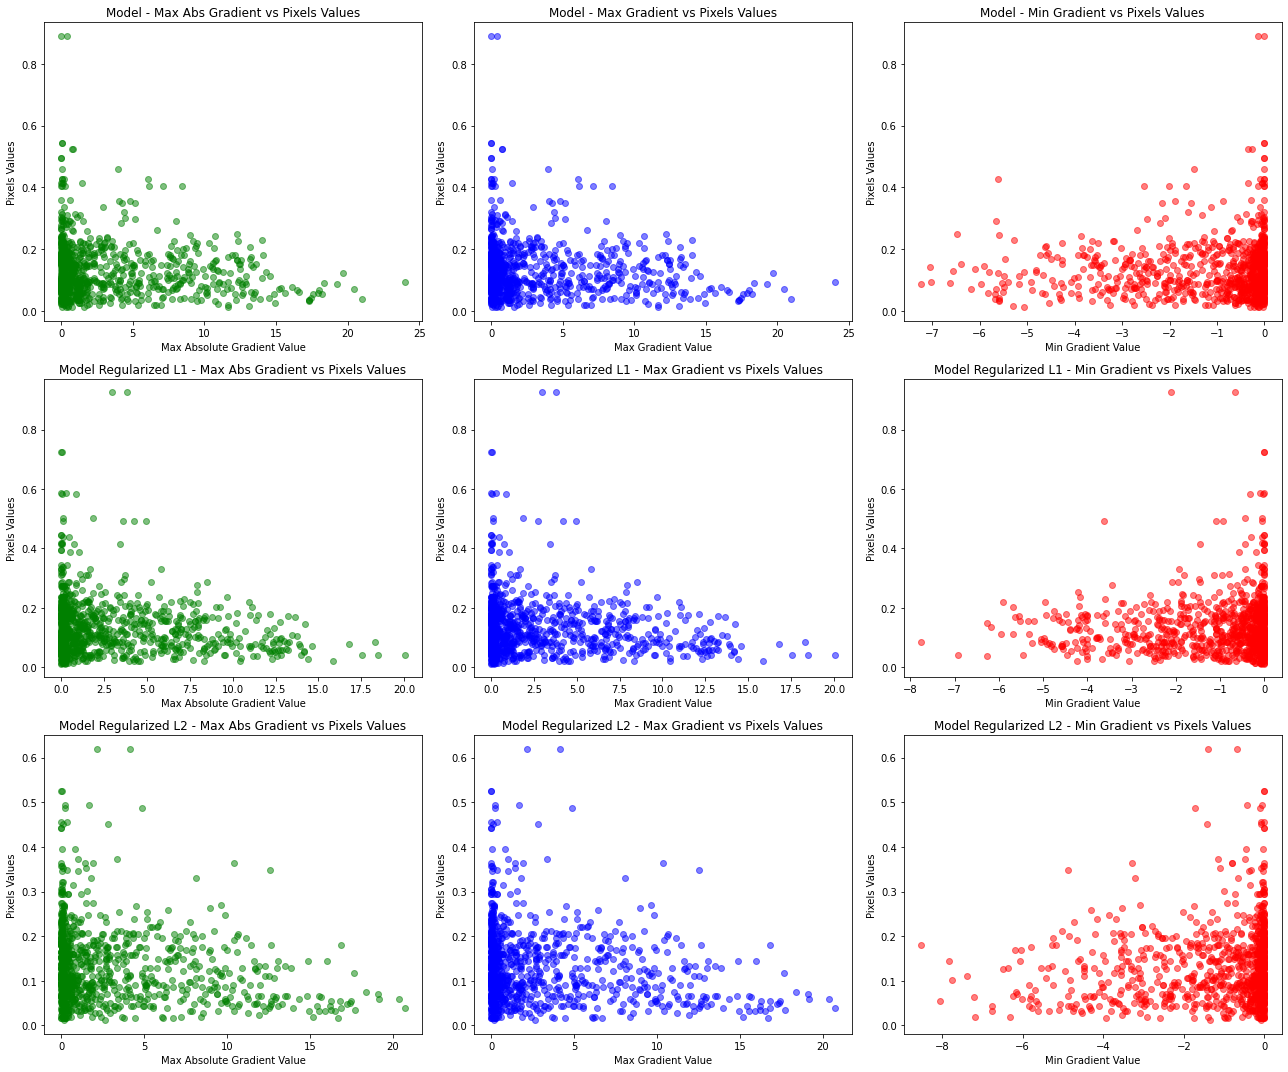

In [56]:
# Function to plot scatter plots for gradient statistics vs Pixels Values
def plot_scatter_stats(gradients, pixels_values, model_name, position):
    max_abs_values = [np.max(np.abs(grad.flatten())) for grad in gradients]
    max_values = [np.max(grad.flatten()) for grad in gradients]
    min_values = [np.min(grad.flatten()) for grad in gradients]

    # Scatter plot for max_abs_values vs Pixels Values
    plt.subplot(3, 3, position)
    plt.scatter(max_abs_values, pixels_values, c='green', alpha=0.5)
    plt.title(f'{model_name} - Max Abs Gradient vs Pixels Values')
    plt.xlabel('Max Absolute Gradient Value')
    plt.ylabel('Pixels Values')

    # Scatter plot for max_values vs Pixels Values
    plt.subplot(3, 3, position + 1)
    plt.scatter(max_values, pixels_values, c='blue', alpha=0.5)
    plt.title(f'{model_name} - Max Gradient vs Pixels Values')
    plt.xlabel('Max Gradient Value')
    plt.ylabel('Pixels Values')

    # Scatter plot for min_values vs Pixels Values
    plt.subplot(3, 3, position + 2)
    plt.scatter(min_values, pixels_values, c='red', alpha=0.5)
    plt.title(f'{model_name} - Min Gradient vs Pixels Values')
    plt.xlabel('Min Gradient Value')
    plt.ylabel('Pixels Values')

# Plotting for each model
plt.figure(figsize=(18, 15))

plot_scatter_stats(gradients_model, pixels_values_model, "Model", 1)
plot_scatter_stats(gradients_model_reg_l1, pixels_values_model_reg_l1, "Model Regularized L1", 4)
plot_scatter_stats(gradients_model_reg_l2, pixels_values_model_reg_l2, "Model Regularized L2", 7)

plt.tight_layout()
plt.show()

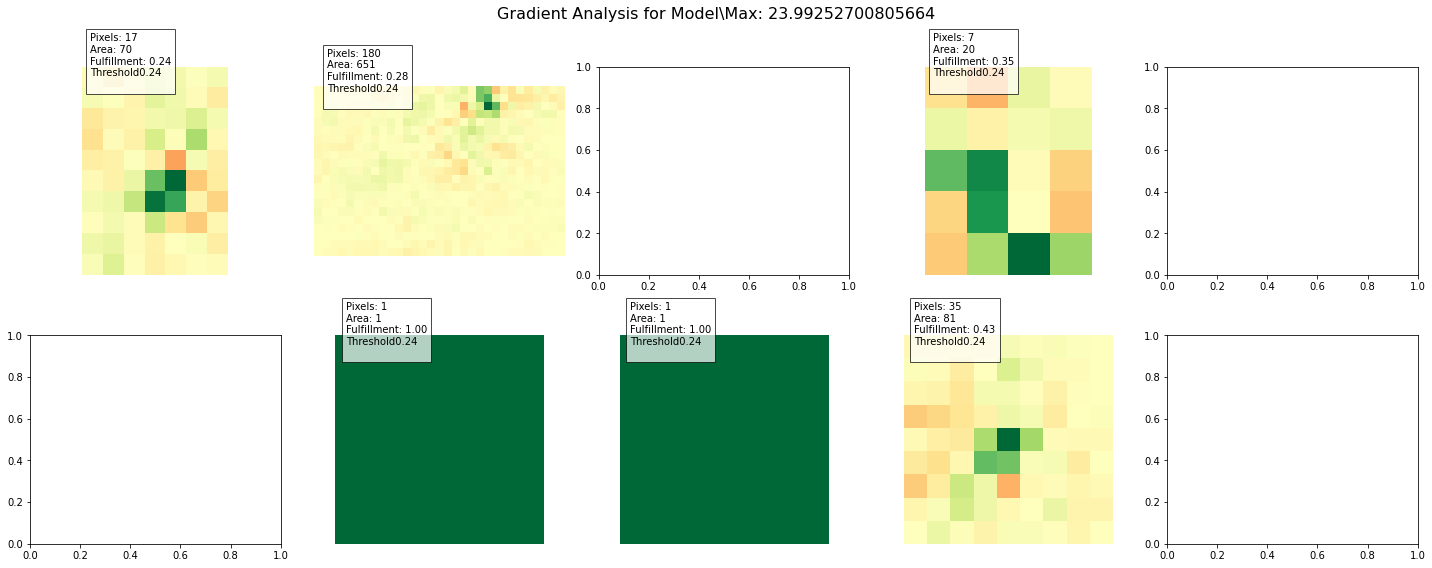

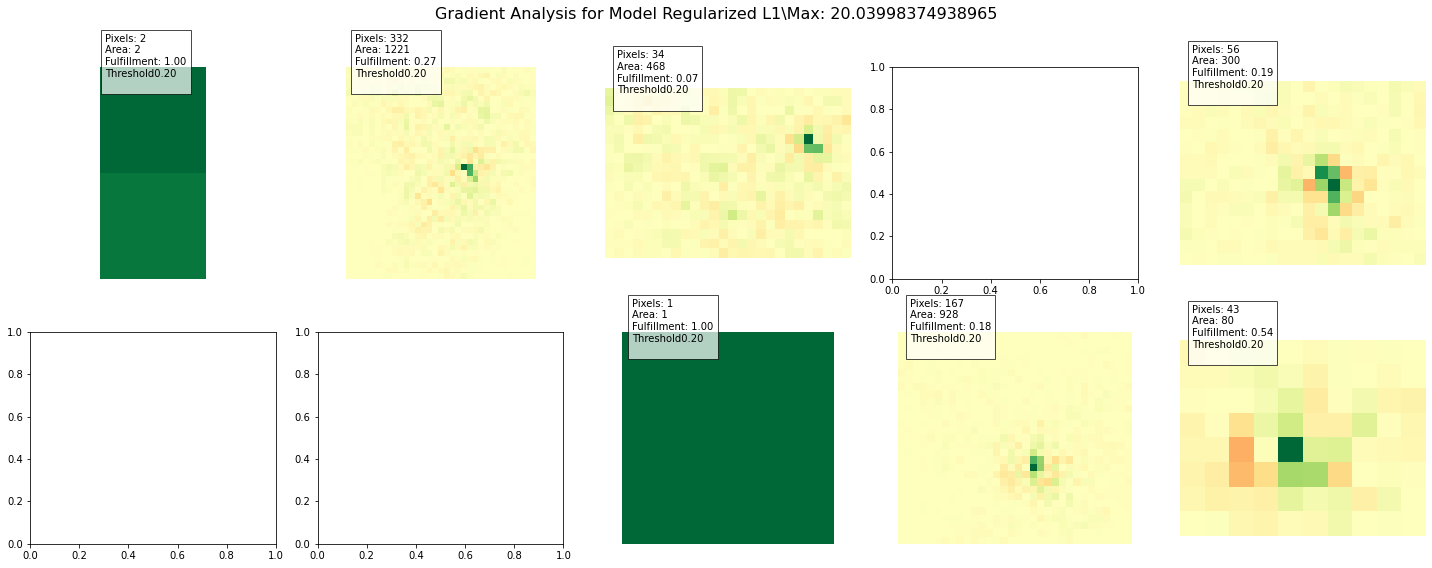

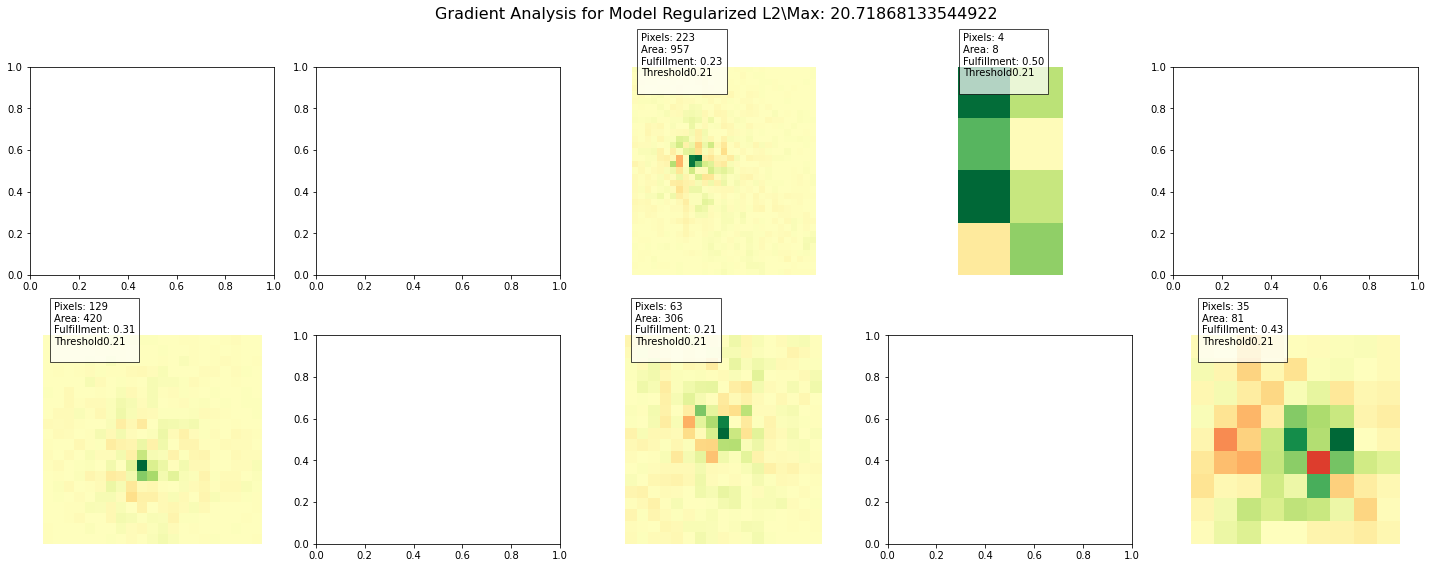

In [57]:
def plot_gradients_with_bounding_box(gradients, num_gradients_to_analyze, model_name, threshold = 0.001):
    num_rows = num_gradients_to_analyze // 5 + (num_gradients_to_analyze % 5 > 0)
    num_cols = min(num_gradients_to_analyze, 5)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))
    
    max = np.max([np.max(np.abs(grad)) for grad in gradients])
    for i in range(num_gradients_to_analyze):
        gradient = gradients[i].squeeze()
        threshold = 0.01 * max
        mask = np.abs(gradient) > threshold
        non_zero_coords = np.nonzero(mask)
        if len(non_zero_coords[0]) > 0:
            y_min, y_max = non_zero_coords[0].min(), non_zero_coords[0].max()
            x_min, x_max = non_zero_coords[1].min(), non_zero_coords[1].max()
            num_pixels_above_threshold = np.sum(mask)
            bounding_box_area = (y_max - y_min + 1) * (x_max - x_min + 1)
            fulfillment = num_pixels_above_threshold / bounding_box_area

            row_index, col_index = i // 5, i % 5
            if num_rows > 1:
                ax = axs[row_index, col_index]
            else:
                ax = axs[col_index]

            ax.imshow(
                gradient[y_min:y_max+1, x_min:x_max+1],
                cmap='RdYlGn',
                vmin=-np.abs(gradient).max(),
                vmax=np.abs(gradient).max(),
                interpolation='nearest'
            )
            #ax.set_title(f'Gradient {i}')
            ax.axis('off')
            ax.text(
                0.05, 0.9,
                f"Pixels: {num_pixels_above_threshold}\nArea: {bounding_box_area}\nFulfillment: {fulfillment:.2f}\nThreshold{threshold:.2f}\n",
                transform=ax.transAxes,
                fontsize=10,
                bbox=dict(facecolor='white', alpha=0.7)
            )
    fig.suptitle(f'Gradient Analysis for {model_name}\Max: {max}', fontsize=16)

    plt.tight_layout()
    plt.show()

# Call the function for each model's gradients
num_gradients_to_analyze = 10
plot_gradients_with_bounding_box(gradients_model, num_gradients_to_analyze, "Model", threshold = 0.001)
plot_gradients_with_bounding_box(gradients_model_reg_l1, num_gradients_to_analyze, "Model Regularized L1", threshold = 0.01)
plot_gradients_with_bounding_box(gradients_model_reg_l2, num_gradients_to_analyze, "Model Regularized L2", threshold = 0.005)

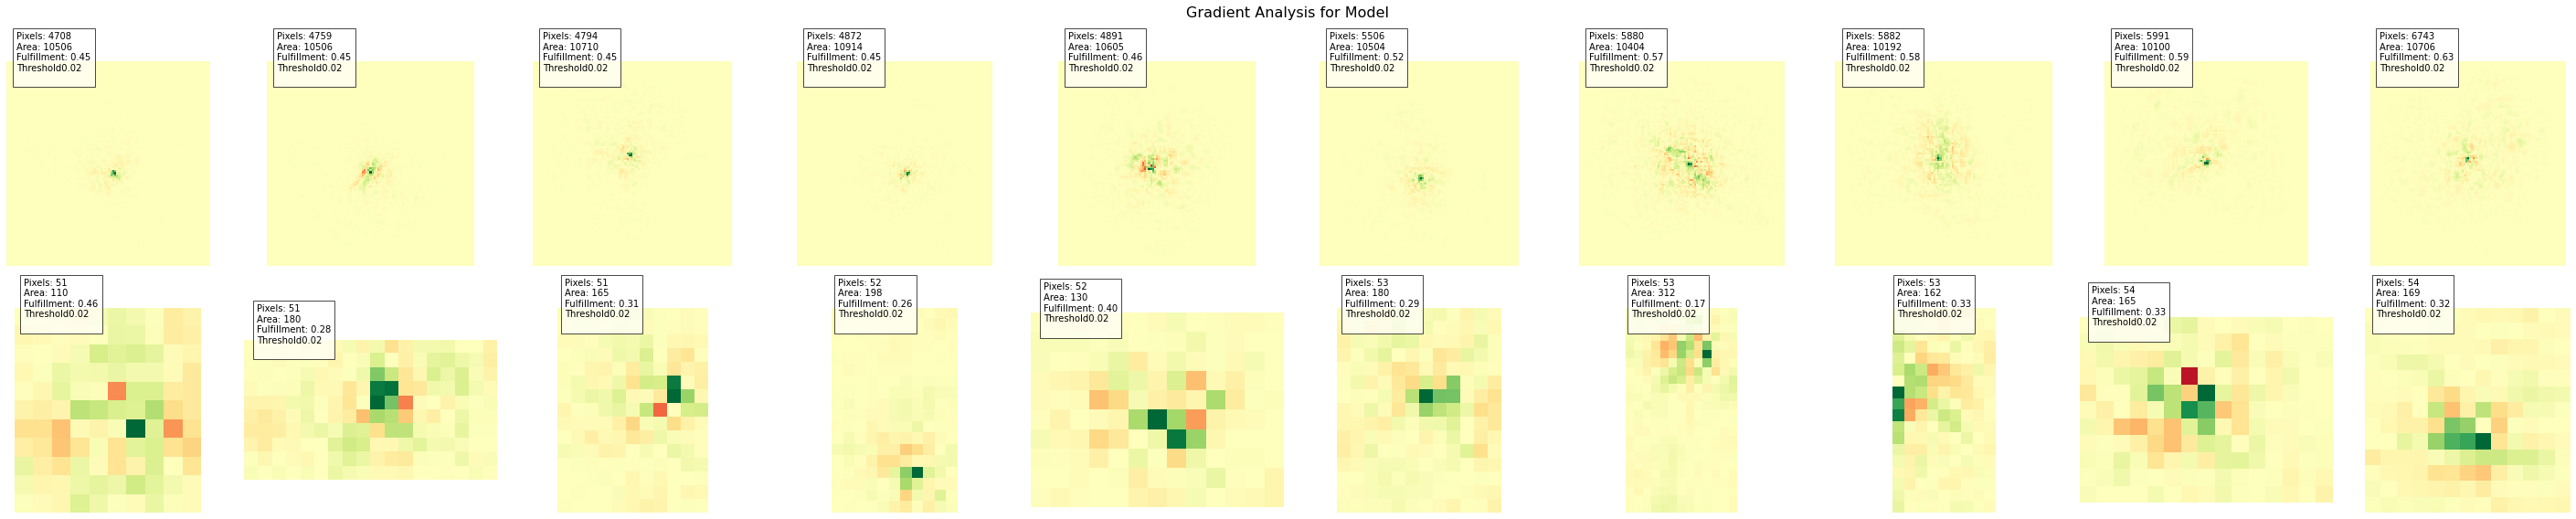

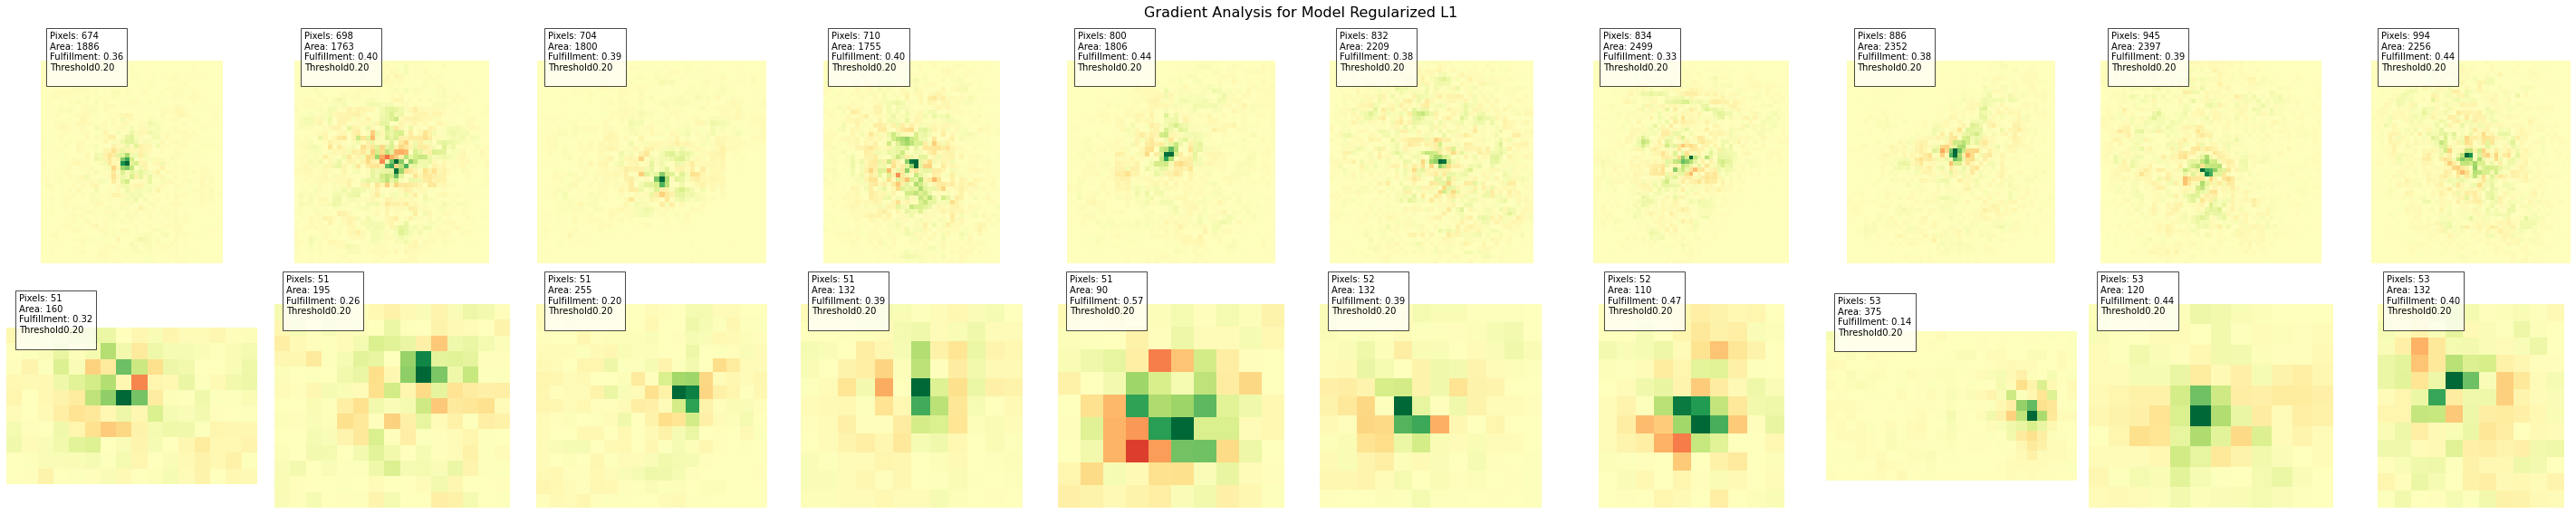

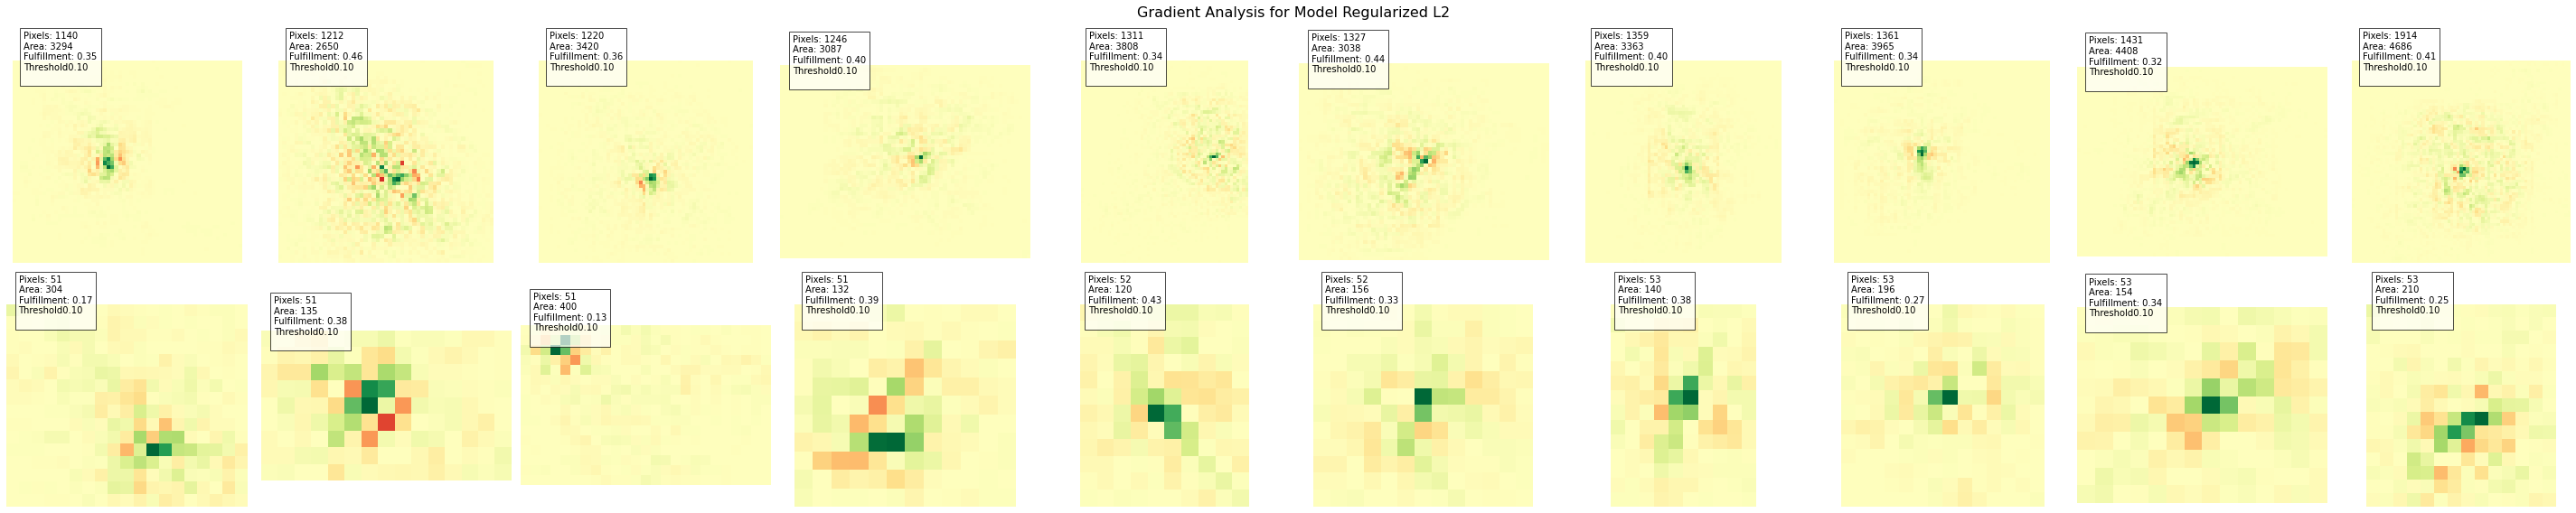

In [58]:
def plot_gradients_with_bounding_box(gradients, model_name, num_gradients_to_display=10, threshold_factor=0.01):
    num_gradients = len(gradients)
    max = np.max([np.max(np.abs(grad)) for grad in gradients])
    threshold = threshold_factor * max
    
    # Sort gradients based on bounding box area
    gradients_sorted = sorted(enumerate(gradients), key=lambda x: np.sum(np.abs(x[1]) > threshold))
    
    # Get the top and bottom gradients
    top_gradients = gradients_sorted[-num_gradients_to_display:]
    bottom_gradients = [gradient for gradient in gradients_sorted if np.sum(np.abs(gradient[1]) > threshold) > 50][:num_gradients_to_display]

    
    fig, axs = plt.subplots(2, num_gradients_to_display, figsize=(num_gradients_to_display * 4, 8))
    
    for i, (gradient_idx, gradient) in enumerate(top_gradients + bottom_gradients):
        gradient = gradient.squeeze()
        mask = np.abs(gradient) > threshold
        non_zero_coords = np.nonzero(mask)
        if len(non_zero_coords[0]) > 0:
            y_min, y_max = non_zero_coords[0].min(), non_zero_coords[0].max()
            x_min, x_max = non_zero_coords[1].min(), non_zero_coords[1].max()
            num_pixels_above_threshold = np.sum(mask)
            bounding_box_area = (y_max - y_min + 1) * (x_max - x_min + 1)
            fulfillment = num_pixels_above_threshold / bounding_box_area

            row_index = i // num_gradients_to_display
            col_index = i % num_gradients_to_display
            ax = axs[row_index, col_index]

            ax.imshow(
                gradient[y_min:y_max+1, x_min:x_max+1],
                cmap='RdYlGn',
                vmin=-np.abs(gradient).max(),
                vmax=np.abs(gradient).max(),
                interpolation='nearest'
            )
            ax.axis('off')
            ax.text(
                0.05, 0.9,
                f"Pixels: {num_pixels_above_threshold}\nArea: {bounding_box_area}\nFulfillment: {fulfillment:.2f}\nThreshold{threshold:.2f}\n",
                transform=ax.transAxes,
                fontsize=10,
                bbox=dict(facecolor='white', alpha=0.7)
            )
    
    fig.suptitle(f'Gradient Analysis for {model_name}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Call the function for each model's gradients
num_gradients_to_display = 10
plot_gradients_with_bounding_box(gradients_model, "Model", num_gradients_to_display, threshold_factor=0.001)
plot_gradients_with_bounding_box(gradients_model_reg_l1, "Model Regularized L1", num_gradients_to_display, threshold_factor=0.01)
plot_gradients_with_bounding_box(gradients_model_reg_l2, "Model Regularized L2", num_gradients_to_display, threshold_factor=0.005)


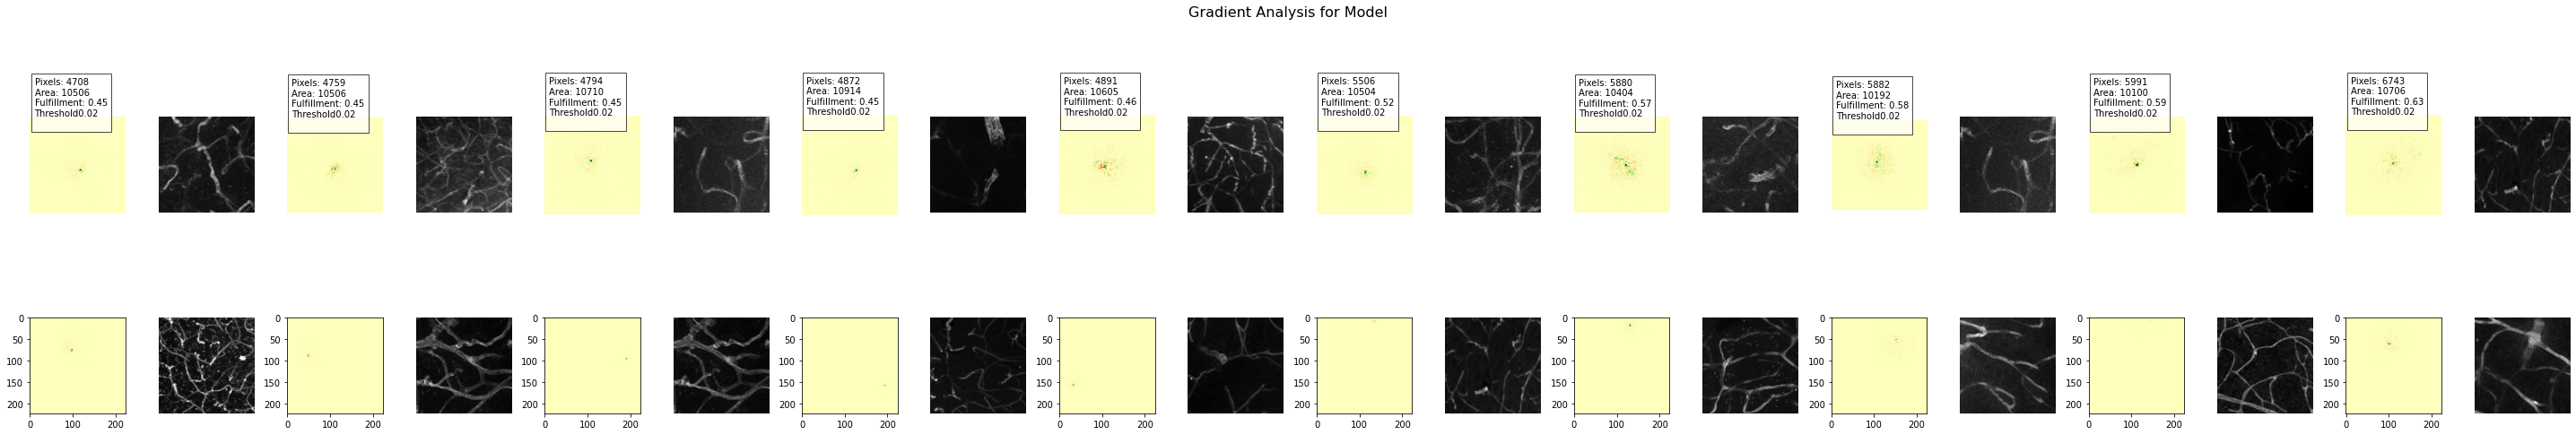

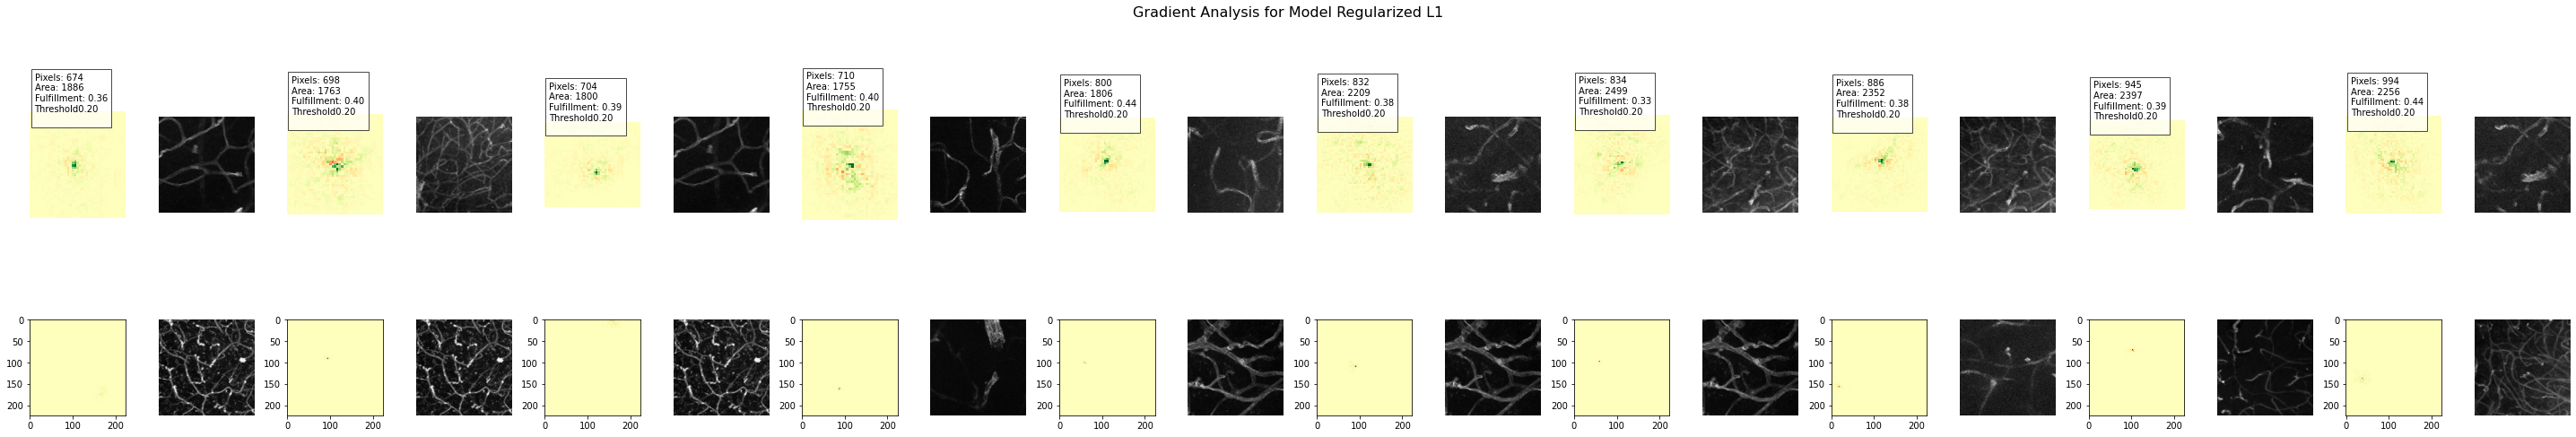

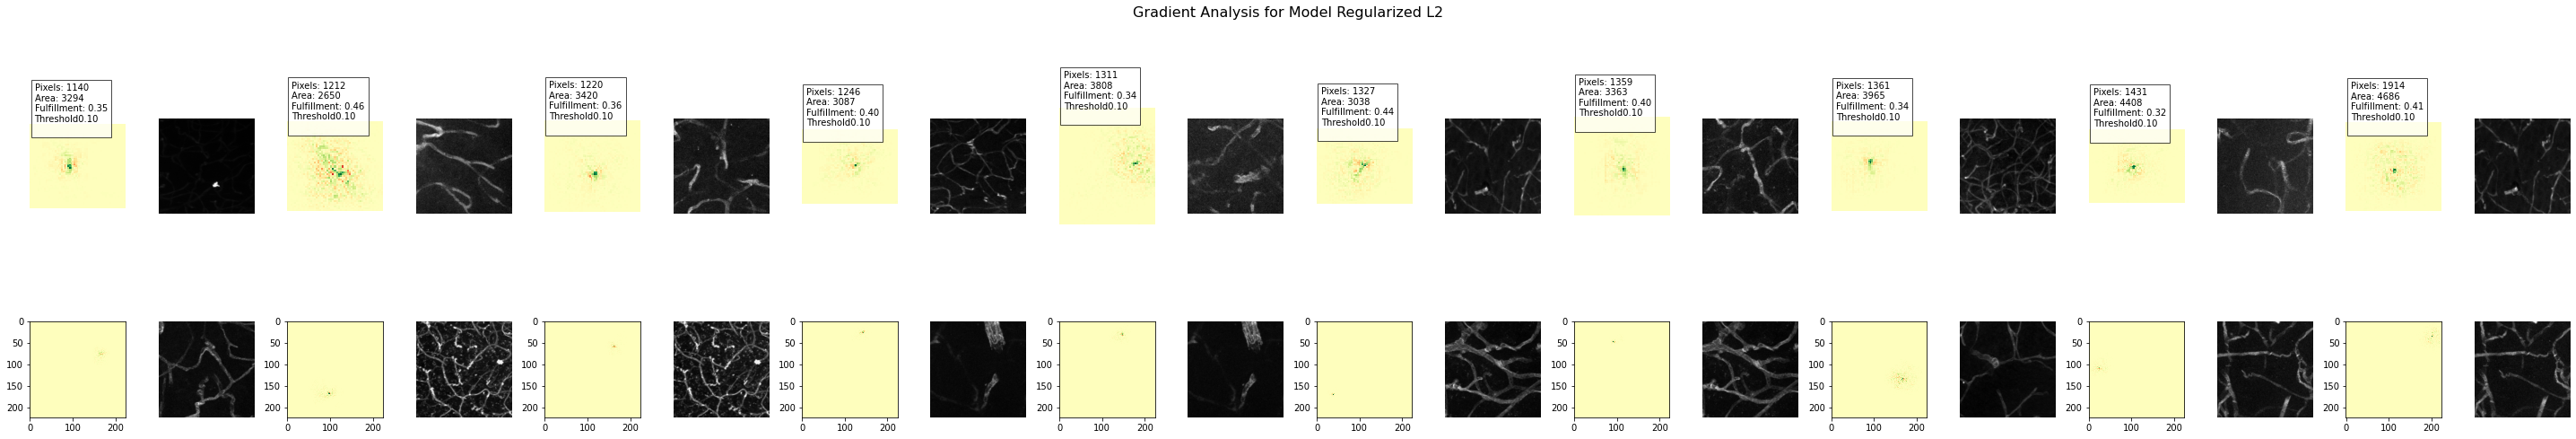

In [71]:
def plot_gradients_with_bounding_box(gradients, images, model_name, num_gradients_to_display=10, threshold_factor=0.01):
    num_gradients = len(gradients)
    max_val = np.max([np.max(np.abs(grad)) for grad in gradients])
    threshold = threshold_factor * max_val
    # Sort gradients based on bounding box area
    gradients_sorted = sorted(enumerate(gradients), key=lambda x: np.sum(np.abs(x[1]) > threshold))
    
    # Get the indices of sorted gradients
    sorted_indices = [idx for idx, _ in gradients_sorted]

    # Sort the images array based on the sorted indices
    sorted_images = [images[idx] for idx in sorted_indices]

    # Get the top and bottom gradients
    top_gradients = gradients_sorted[-num_gradients_to_display:]
    bottom_gradients = [gradient for gradient in gradients_sorted if np.sum(np.abs(gradient[1]) > threshold) >= 0][:num_gradients_to_display]

    # Get the top and bottom images
    top_images = sorted_images[-num_gradients_to_display:]
    sorted_indices = [idx for idx, _ in bottom_gradients]
    bottom_images = [sorted_images[idx] for idx in sorted_indices]

    fig, ax = plt.subplots(2, num_gradients_to_display*2, figsize=(num_gradients_to_display * 4, 8))
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.5, wspace=0.2)  
    
    for i, (gradient, img) in enumerate(zip(top_gradients + bottom_gradients, top_images + bottom_images)):
        gradient = gradient[1].squeeze()  # Unpack the gradient tuple and squeeze it
        mask = np.abs(gradient) > threshold
        non_zero_coords = np.nonzero(mask)
        row = i // (num_gradients_to_display)
        col = i % (num_gradients_to_display) * 2
        
        if len(non_zero_coords[0]) > 0:
            y_min, y_max = non_zero_coords[0].min(), non_zero_coords[0].max()
            x_min, x_max = non_zero_coords[1].min(), non_zero_coords[1].max()
            num_pixels_above_threshold = np.sum(mask)
            bounding_box_area = (y_max - y_min + 1) * (x_max - x_min + 1)
            fulfillment = num_pixels_above_threshold / bounding_box_area

            ax[row][col].imshow(
                gradient[y_min:y_max+1, x_min:x_max+1],
                cmap='RdYlGn',
                vmin=-np.abs(gradient).max(),
                vmax=np.abs(gradient).max(),
                interpolation='nearest'
            )
            ax[row][col].axis('off')
            ax[row][col].text(
                0.05, 0.9,
                f"Pixels: {num_pixels_above_threshold}\nArea: {bounding_box_area}\nFulfillment: {fulfillment:.2f}\nThreshold{threshold:.2f}\n",
                transform=ax[row][col].transAxes,  # Changed from ax.transAxes
                fontsize=10,
                bbox=dict(facecolor='white', alpha=0.7)
            )
        else:
            ax[row][col].imshow(
                gradient,
                cmap='RdYlGn',
                vmin=-np.abs(gradient).max(),
                vmax=np.abs(gradient).max(),
                interpolation='nearest'
            )
            
        # Add image on the side
        ax_image = ax[row][col+1]
        ax_image.imshow(img.detach().cpu().numpy().transpose(1, 2, 0), cmap='gray')
        ax_image.axis('off')
    
    fig.suptitle(f'Gradient Analysis for {model_name}', fontsize=16)
    plt.tight_layout()
    plt.show()

expanded_images = []

# Iterate over each image in the original array
for image in all_images:
    # Add the original image to the new array
    expanded_images.append(image)
    
    # Add 9 more copies of the same image
    expanded_images.extend([image] * 9)

# Call the function for each model's gradients
num_gradients_to_display = 10
plot_gradients_with_bounding_box(gradients_model, expanded_images, "Model", num_gradients_to_display, threshold_factor=0.001)
plot_gradients_with_bounding_box(gradients_model_reg_l1, expanded_images, "Model Regularized L1", num_gradients_to_display, threshold_factor=0.01)
plot_gradients_with_bounding_box(gradients_model_reg_l2, expanded_images, "Model Regularized L2", num_gradients_to_display, threshold_factor=0.005)
